# Feature representation: Manifold learning

In [13]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import collections
from torchvision import datasets, models, transforms
use_gpu = torch.cuda.is_available()

In [10]:
data_transforms = {
   'train': transforms.Compose([
       transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
datasets.folder.IMG_EXTENSIONS.append('tif')
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

We extract the 512-features from resnet18 network.

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.load_state_dict(torch.load('modelbest'))
model_ft = model_ft.eval()
if use_gpu:
    model_ft=model_ft.cuda()
num_ftrs = model_ft.fc.in_features
                         
modules = list(model_ft.children())[:-1]
resnet18_feature = nn.Sequential(*modules)


features_train=[]
features_val=[]
classes_train=[]
classes_val=[]
for data in ['train','val']:
    for i,(images,labels) in enumerate(dataloaders[data]):
        img=Variable(images)
        if use_gpu:
            img=img.cuda()
        out=resnet18_feature.forward(img)
        out=out.view(-1,512).cpu().data.numpy()
        labels=labels.numpy()
        if data=='train':
            features_train.append(out)
            classes_train.append(labels)
        else:
            features_val.append(out)
            classes_val.append(labels)
features_train=np.vstack(features_train)
classes_train=np.hstack(classes_train)
features_val=np.vstack(features_val)
classes_val=np.hstack(classes_val)

print('train features size:{}\tlabels size:{}'.format(features_train.shape,classes_train.shape))
print('val features size:{}\tlabels size:{}'.format(features_val.shape,classes_val.shape))

train features size:(8680, 512)	labels size:(8680,)
val features size:(751, 512)	labels size:(751,)


Here, we compare 8 popular methods in Manifold Learning on the validation set:

PCA,Isomap,MDA,t-SNE,LLE,LTSA,Hessian LLE,Modified LLE.

Most of them maintain special distances between all points while the other reduce dimension through different approaches. t-SNE, for example, converts Gaussian joint probabilities in the original space into Student's t distribution in the embedded space.

In [12]:
import seaborn
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap,MDS,TSNE,LocallyLinearEmbedding,SpectralEmbedding

LLE_dict=dict(zip(['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE'],
                    ['standard', 'ltsa', 'hessian', 'modified']))
methods=['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE','Isomap','MDS','TSNE','PCA']

fig_features_1=plt.figure(1,figsize=(18,9))
fig_features_1.suptitle('Manifold Learning for ResNet Features')

for i,method in enumerate(methods):
    print('{} starts......'.format(method))
    if method in LLE_dict.keys():
        manifold=LocallyLinearEmbedding(n_neighbors=6,method=LLE_dict[method],eigen_solver='dense')
    elif method=='MDS':
        manifold=MDS(n_init=1,max_iter=100)
    elif method=='PCA':
        exec('manifold={}(n_components=2)'.format(method))
    elif method=='TSNE':
        exec('manifold={}(n_components=2,init="pca")'.format(method))
    else:
        exec('manifold={}(n_neighbors=6)'.format(method))
    features_2D=manifold.fit_transform(features_val.astype(np.float64))
    np.save('features_2d_{}'.format(method),features_2D)
    
    ax=fig_features_1.add_subplot(241+i)
    ax.scatter(features_2D[np.where(classes_val==1),0],features_2D[np.where(classes_val==1),1],s=3,c='blue',label='fake')
    ax.scatter(features_2D[np.where(classes_val==0),0],features_2D[np.where(classes_val==0),1],s=3,c='lime',label='authentic')
    ax.legend(loc='upper right',prop={'size':11})
    ax.set_title(method)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    
fig_features_1.savefig('Manifold_of_ResNet.png')

LLE starts......
LTSA starts......
Hessian LLE starts......
Modified LLE starts......
Isomap starts......
MDS starts......
TSNE starts......
PCA starts......


The result is as follows:

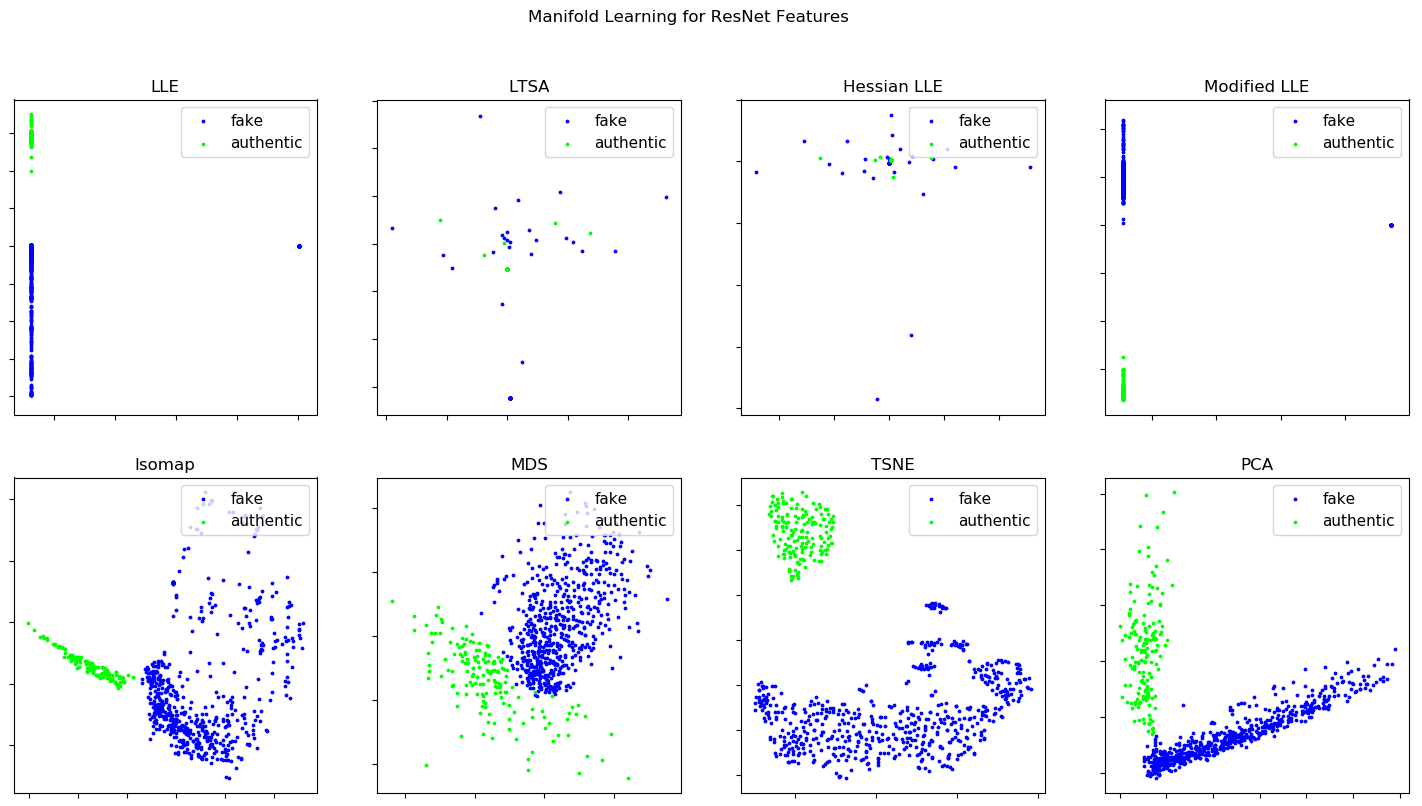

In [13]:
fig_features_1

_Obviously, in the last four picture, the boundary for two classes is very clear._

# Predicting Disputed Pictures

Based on output labels of our model, let's identify those disputed pictures.
Probability = percentage of 'authentic' labelled pieces 

In [3]:
from pred import predictor
predict = predictor(model_ft)

In [4]:
predict.prediction('data/disputed')

In [29]:
for key in sorted(predict.prob.keys(), key=int):
    print(key, ':', predict.prob[key])

1 : 0.25
7 : 0.1118420958518982
10 : 0.34343433380126953
20 : 0.024705886840820312
23 : 0.8666666597127914
25 : 0.9176470562815666
26 : 0.4833333492279053


# Visualization of Result Directly on Painting
Since our model is based on the patch of orginal Raphael painting, we can visualize our model output on the painting by drawing figures on different patches in the same painting. This method helps us understand the performance of our model on different texture.

In [6]:
import torch 
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.autograd import Variable

import os

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import numpy as np
import glob


%matplotlib inline

### Load the trained model 

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.load_state_dict(torch.load('modelbest'))
model_ft.eval()

### Read the label

In [8]:
pic_dir = 'Raphael_Project'

filelist = os.listdir(pic_dir)

#remove file which name does not start with digit 
for _ in filelist:
    if _[0].isdigit() == False:
        filelist.remove(_)
        
filelist = sorted(filelist, key=lambda x:int(x.split('.')[0]))

disputed_id = np.array([1, 7, 10, 20, 23, 25, 26])
authentic_id = np.array([2, 3, 4, 5, 6, 8, 9, 21, 22, 24, 27, 28]) 
fake_id = np.array([11, 12 ,13, 14, 15, 16, 17, 18, 19]) 
labels = dict(**{str(x):'fake' for x in fake_id}, **{str(x):'disputed' for x in disputed_id}, 
              **{str(x):'authentic' for x in authentic_id})


## Draw the Significance Level distribution on orginal photot

In this part, we calculate probability for each patch given a painting, and draw cycle on the corresponding patch on the orginal painting. The more green, the more possible this patch is authentic, and the more blue, the more possible this patch is fake. Meanwhile, the size of cycle refers to the strength level of probability, i.e.
$$ cycle\ size = f({\lVert}{prob - \frac{1}{2}}{\rVert})$$

### select a authentic, a fake and a disputed painting to show

In [30]:
#randomly take pictures from authentic, fake and disputed set
id_r = np.random.choice(authentic_id)
id_nr = np.random.choice(fake_id)
id_disp = 1
name_r = [f for f in filelist if f.startswith(str(id_r))][0]
name_nr = [f for f in filelist if f.startswith(str(id_nr))][0]
name_disp = [f for f in filelist if f.startswith(str(id_disp))][0]

In [28]:
def resize_pic(pic_path, resize_factor = 0.25): # Resize picture to fit the output area
    org_img = Image.open(pic_path)
    wsize = int(org_img.size[0]*resize_factor)
    hsize = int(org_img.size[1]*resize_factor)
    img = org_img.resize((wsize,hsize), Image.ANTIALIAS)
    return img

def show_pic(img):
    plt.figure(figsize=(15,15))
    plt.imshow(np.asarray(img))
    
def res_loc(point_loction, resize_factor=0.25): # Resize the location of cycle to fit the resized picture 
    return point_loction*resize_factor
    
transform_pic = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### authentic painting 

In [ ]:
img_r = resize_pic(os.path.join(pic_dir,name_r))
show_pic(img_r)

### fake painting 

In [ ]:
img_nr = resize_pic(os.path.join(pic_dir,name_nr))
show_pic(img_nr)

### disputed painting

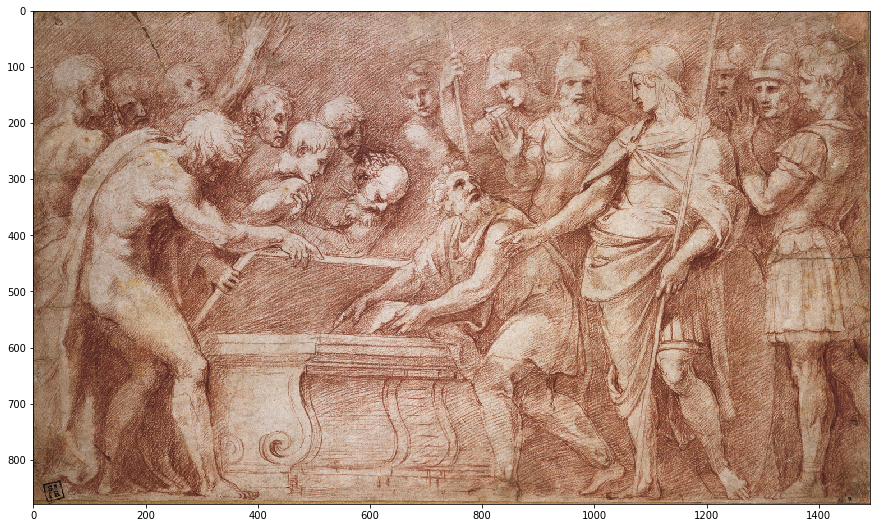

In [30]:
img_disp = resize_pic(os.path.join(pic_dir,name_disp))
show_pic(img_disp)

## Compute Signifiance Level for Each Patch 

Given a patch, our model return a data structure containing 2 numbers, the 'authentic' score and 'fake' score. We can calculate probability of the 'authentic' based on the 2 number.

The probability of 'authentic' can be regarded as 

$$ P(Authentic) = \frac{e^{score(Authentic)}}{e^{score(Authentic)}+e^{score(Fake)}} \quad. $$

Therefore 

$$ \frac{P(Authentic)}{P(Fake)} = e^{score(authentic)-score(fake)} \quad.$$

So, we only need to store the difference of the two scores. The difference is stored as '$sig\_mat$' and 
$$ P(Authentic) = \frac{e^{sig\_mat}}{e^{sig\_mat}+1} $$

num of patch scored:100
num of patch scored:200
total num of patch scored:276
------------------------------

num of patch drawn: 100
num of patch drawn: 200
total num of patch drawn: 276
------------------------------



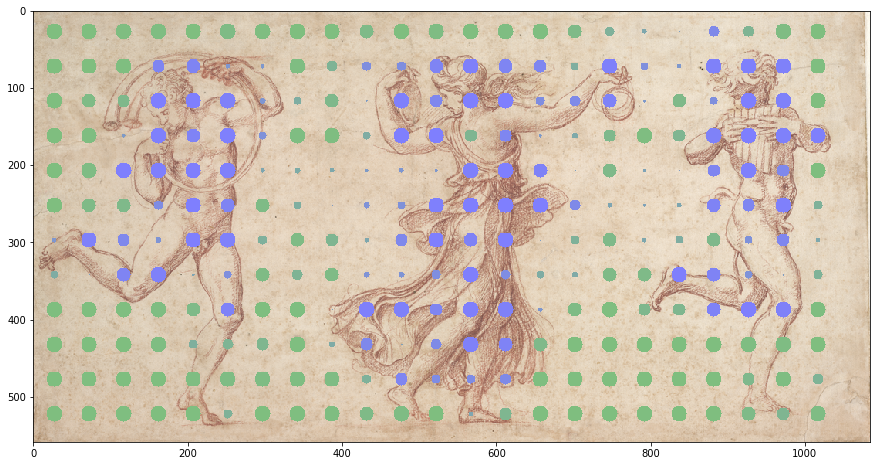

In [31]:
pic_name = name_disp
pic_path = os.path.join(pic_dir,pic_name)
org_img = Image.open(pic_path)
w, h = org_img.size

cropped_size = (224, 224)
w_crop, h_crop = cropped_size
w_offset, h_offset =  (180,180)
w_p, h_p = (0,0) # horizontal point, ..
n_w, n_h = (0,0) # index of patch 

while w_p + w_crop < w: # num of horizontal patch 
    n_w = n_w + 1
    w_p += w_offset
    
while h_p + h_crop < h: # num of vertical patch 
    n_h = n_h + 1
    h_p += h_offset

sig_mat = np.zeros((n_w, n_h))

w_p, h_p = (0,0) # horizontal point, ..
n_w, n_h = (0,0) # index of patch 
count = 0
# find the cropped patch, feed it to the model, get the score 
while w_p + w_crop < w:
    while h_p + h_crop < h:
        #locate the position
        file_name = pic_name.split('.')[0] + '-'  + str(w_p) + '-' + str(h_p)  + '.tif'
        pic = Image.open(glob.glob('data/**/'+file_name, recursive=True)[0])
        img = transform_pic(pic)[0:3,:,:].unsqueeze(0)
        score = model_ft(Variable(img)).data[0]
        diff = score[0]-score[1]
        sig_mat[n_w, n_h] = diff 
        h_p = h_p + h_offset
        n_h += 1
        count += 1 
        if count%100 == 0:
            print("num of patch scored:{num}".format(num=count))
    h_p = 0
    n_h = 0
    w_p = w_p + w_offset
    n_w += 1
print("total num of patch scored:{num}".format(num=count))
print("------------------------------\n")

ratio = np.exp(sig_mat)
prob = np.divide(ratio, ratio+1) # prob matrix, each element is the prob for corresponding patch

img = resize_pic(pic_path)
draw = ImageDraw.Draw(img)
cycle_size = 20
count = 0

w_p, h_p = (0,0)
n_w, n_h = (0,0)

while w_p + w_crop < w:
    while h_p + h_crop < h:
        #locate the position
        p = prob[n_w, n_h]
        prob_level = np.absolute(p - 0.5) 

        w_p_c = res_loc(w_p + int(cropped_size[0]/2)) #center point in the resized picture
        h_p_c = res_loc(h_p + int(cropped_size[1]/2)) 

        x1 = int(w_p_c - prob_level*cycle_size)
        y1 = int(h_p_c - prob_level*cycle_size)
        x2 = int(w_p_c + prob_level*cycle_size) 
        y2 = int(h_p_c + prob_level*cycle_size)

        color = (0, int(128*p), int(255*(1-p)), 128) # Blue:(0,0,255) Green(0,128,0)
        # if the patch is authentic, there will be a green cycle 
        # else, a blue cycle
        draw.ellipse((x1, y1, x2, y2), fill= color, outline = color)
        h_p = h_p + h_offset
        n_h += 1        
        count += 1 
        if count%100 == 0:
            print("num of patch drawn: {num}".format(num=count))
    h_p = 0
    n_h = 0
    w_p = w_p + w_offset
    n_w += 1

print("total num of patch drawn: {num}".format(num=count))
print("------------------------------\n")

show_pic(img)

result_path= 'result'
try:
    if not os.path.exists(result_path):
            print('creat folder:',result_path)
            #os.mkdir(file_path)
            os.makedirs(result_path)
except IOError as e:
    print('file operation fail',e)
except Exception as e:
    print('error ：',e)

img.save(os.path.join(result_path,str(np.around(np.mean(prob)*100, decimals=2))+ '%_' + pic_name))
del draw


_The above is the prediction on the painting 1. Since we crop whole picture into several small patches, we make the prediction on every small picture. The size of blue circles stands for the probability that this patch is fake while green circles imply authenticity. So we can claim that this painting is fake. Compared with identifying directly from classification probabilities, the visualization is clear for readers and also works better for pictures which are hard to judge like this painting 1._


_There is another result as follows:_
![avatar](painting_26.png)

_This is the visualization of painting 26. One can notice that most of patches are green circles except the middle strip which seems to be masked by some dirts. So we would like to treat it as an authentic painting if discarding the dirty strip._